# Homework 4: Generalizaiton and regularization



# 0 - Introduction to PyTorch and Autograd

In Week 2, we introduced the concept of a `computational graph`, which is used to efficiently compute gradients in deep neural networks. The key idea is to track intermediate values during forward computation, as these values are used again for backpropagation. By storing these intermediate values, we can significantly reduce the computational cost during gradient computation.

This concept of using a computational graph to compute gradients is implemented in PyTorch, originally developed by Facebook’s AI Research (FAIR) group (now part of Meta), through a process called **automatic differentiation**, also known as `autograd`.

Similar to `numpy`, in PyTorch, we define variables as **tensors**. PyTorch tensors have an additional feature: if `requires_grad=True`, they automatically track operations for gradient computation.

In [ ]:
import torch

torch.manual_seed(0) # seed for reproducing

x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z = x ** 2 + 2*y ** 2

print(f"x.requires_grad: {x.requires_grad}")
print(f"y.requires_grad: {y.requires_grad}")
print(f"z.requires_grad: {z.requires_grad}")

x.requires_grad: True
y.requires_grad: True
z.requires_grad: True


In this example:

- `x` and `y` are tensors with `requires_grad=True`, meaning they are being tracked for gradient computation.
- The result, `z`, also has `requires_grad=True`, since it's the result of an operation involving tensors that require gradients.

We define two tensor variables, `x` and `y`, and set `requires_grad=True` to indicate that PyTorch should track their gradients. This means that PyTorch will construct a computational graph involving `x` and `y` whenever operations are performed on them.

In this example, we use `x` and `y` to compute `a`. To compute the gradients of `z` with respect to `x` and `y`, we simply call `z.backward()`. This applies the **chain rule**, propagating the gradients backward through the computational graph. The gradients of `z` with respect to `x` and `y` can then be accessed by calling `x.grad` and `y.grad`.

In [ ]:
z.backward()
print(f"Gradient of x: {x.grad}")
print(f"Gradient of y: {y.grad}")

Gradient of x: 2.0
Gradient of y: 8.0


We can also visualize the computational graph by inspecting `z.grad_fn`, which shows the function that created `z`. This is useful for understanding how PyTorch constructs the graph and tracks operations. Each operation is represented as a node in the graph, and by calling `grad_fn`, we can see the chain of operations that led to the final result, allowing us to trace the graph backward for gradient computation.

In [ ]:
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z = x ** 2 + 2*y ** 2
a = torch.sin(z)

print(f"a.requires_grad: {a.requires_grad}")
print(a.grad_fn)
print(a.grad_fn.next_functions)
print(z.grad_fn)
print(x.grad_fn)

a.requires_grad: True
((<AddBackward0 object at 0x7fcd1f42e5f0>, 0),)
None


In this example:
- `print(a.grad_fn)`: Shows the function that created `a`, which will be `SinBackward`, indicating a was generated by the `sin` operation.

- `print(a.grad_fn.next_functions)`: Displays the previous functions in the graph that led to `a`. This shows the operations applied to `z` before `sin`.

- `print(z.grad_fn)`: Prints the function that created `z` (i.e., `AddBackward`), which matches `a.grad_fn.next_functions`.
- `print(x.grad_fn)`: This shows `None` because `x` is a leaf tensor, meaning it was not created by any function but was initialized directly. Leaf tensors do not have a `grad_fn`.

To stop gradient tracking, we can use `.detach()` to remove a tensor from the computational graph. In this example, we detach the tensor `x`, creating `x_detached`. When we call `a.backward()`, the detached tensor will not have gradients, and its `requires_grad` flag will be set to `False`.

In [ ]:
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z = x ** 2 + 2*y ** 2

x_detached = x.detach()
z.backward()

print(f"x.requires_grad: {x.requires_grad}")
print(f"x_detached.requires_grad: {x_detached.requires_grad}")

print(f"x.grad: {x.grad}")
print(f"x_detached.grad: {x_detached.grad}")

x.requires_grad: True
x_detached.requires_grad: False
x.grad: 2.0
x_detached.grad: None


However, it's important to note that `x_detached` is not a **deep copy** of `x`. Both tensors share the same memory location, but `x_detached` is excluded from the computational graph used for automatic differentiation. This means if you modify `x_detached` **in-place**, the value of `x` may also change.

To avoid this, if you want to modify `x_detached` without affecting the original `x`, you can use `x.clone()` to create an actual copy of the tensor.

To reduce this probalic senario, if you want to modify the value of `x_detached` but dont want to effect the value in the original `x`. You can use `x.clone()` to get a copy of `x`.

In [ ]:
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z = x ** 2 + 2*y ** 2

x_clone = x.clone()
x_clone = torch.tensor(5.0)
print(f"x_clone: {x_clone}")
print(f"x: {x}")

print(f"x_clone.requires_grad: {x_clone.requires_grad}")

x_clone: 5.0
x: 1.0
x_clone.requires_grad: False


In PyTorch, when you use the `clone()` method, the cloned tensor retains the same `requires_grad` setting as the original tensor. So if the original tensor `x` has `requires_grad=True`, the cloned tensor `x_clone` will also have `requires_grad=True`. This is why, in your example, `x_clone.requires_grad` is `True`.

If you want the cloned tensor to **not track gradients**, you can explicitly set `requires_grad=False` after cloning:

In [ ]:
x_clone = x.clone().detach()
print(f"x_clone.requires_grad: {x_clone.requires_grad}")

x_clone.requires_grad: False


Another way to **temporarily** prevent gradient tracking when you only need to use the current value of `x` for some computation is to use `torch.no_grad()`. This context manager disables gradient tracking for all operations inside its block, making it useful when you want to perform computations without affecting the computational graph.

In [ ]:
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z = x ** 2 + 2 * y ** 2

with torch.no_grad():
    a = torch.sin(x)

print(f"a.requires_grad: {a.requires_grad}")

a.requires_grad: False


After exiting the `no_grad()` block, a no longer tracks gradients, as confirmed by `a.requires_grad` being `False`. This is useful when you want to do computations that don’t need gradients, such as during the inference phase or when updating non-trainable parameters.

# 1 - Build a Neural Network and Train using `autograd`

We have briefly introduced how `autograd` uses computational graphs to efficiently compute gradients. Now, let's use `autograd` to train a deep neural network (DNN).

## 1.1 - Define `ShallowNet` [10/10]

The first step is to define a two-layer neural network class called `ShallowNet` using `torch.nn`.

**Exercise 1 [10/10]**
1. The `ShallowNet` takes input size `n_x`, output size `n_y`, and width `n_h`.
2. Instead of manually specifying weights and biases, use `nn.Linear()` to define **linear transformations** to compute preactivation that include weights and biases internally.
3. Define the activation function `self.act` as a class attribute using `nn.ReLU()`.
4. Implement the `forward()` method to perform forward propagation and return the output of the network.

**Note** that, thanks to `autograd()`, you don't need to manually implement *backpropagation* as you did before.



In [ ]:
import torch.nn as nn

class ShallowNet(nn.Module):
    def __init__(self, n_x, n_h, n_y):
        super(ShallowNet, self).__init__()
        self.fc1 = nn.Linear(n_x, n_h)
        self.fc2 = nn.Linear(n_h, n_y)
        self.act = nn.ReLU()

    def forward(self, x):
        # Forward pass: x -> linear() -> act() -> linear()
        ### Code Here ###

        ### Code Here ###
        return x


In [ ]:
# Example of how to initialize the network
n_x = 4  # Input size
n_h = 10  # Hidden layer width
n_y = 1  # Output size

model = ShallowNet(n_x, n_h, n_y)
print(model)

ShallowNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (act): ReLU()
)


In [ ]:
num_samples = 8
x = torch.randn(num_samples, n_x)
output = model(x)
print(output)

tensor([[ 0.3817],
        [ 0.3093],
        [ 0.2687],
        [ 0.1068],
        [-0.0068],
        [ 0.0091],
        [ 0.1560],
        [ 0.1721]], grad_fn=<AddmmBackward0>)


Explanation:
- `nn.Linear(n_x, n_h)`: Defines a fully connected layer from input size `n_x` to hidden layer size `n_h`.
- `self.act = nn.ReLU()`: Defines the ReLU activation function.
- `forward()` method: Implements the forward propagation, applying the activation function after the first layer and passing the result through the second layer to produce the output.

You can now use `autograd()` to automatically handle backpropagation during training.

## 1.2 - Define Loss Function and Optimizer [10/10]

To train the `ShallowNet`, we need to specify both a loss function and an optimizer. For example, we can use `nn.MSELoss()` as the loss function, and `torch.optim.SGD()` as the optimizer. The optimizer requires `model.parameters()` and a learning rate, which we define as `learning_rate`.

In [ ]:
# Define the loss function
criterion = nn.MSELoss()  #

# Define the optimizer (SGD)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Next, let's train this simple neural network using *full-batch gradient descent*, where we use all the training data in each step, instead of mini-batches.

**Exercise 2 [10/10]:**
1. In each training loop, evaluate the `model` on the entire training set `x` to obtain the `output`.
2. Compute the `loss` by using the predefined loss function `criterion` and comparing the `output` with the ground truth labels `y`.
3. Use autograd to compute the gradients by calling `loss.backward()` instead of calling `model.backward()` like we did in the last assignment
4. The computed gradients are automatically stored in the `model`’s parameters, which are passed into the `optimizer`. Apply a gradient descent update by calling `optimizer.step()` as done in the previous assignment.


In [ ]:
# Generate random data (full-batch)
torch.manual_seed(0) # For reproduce

x = torch.randn(num_samples, n_x)
y = torch.randn(num_samples, 1)

num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Clear previous gradients

    # Forward pass
    ### Code Here ###


    ### Code Here ###

    # Backward pass and optimization
    ### Code Here ###


    ### Code Here ###

    # Print the loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.9464
Epoch [2/10], Loss: 0.9357
Epoch [3/10], Loss: 0.9255
Epoch [4/10], Loss: 0.9158
Epoch [5/10], Loss: 0.9066
Epoch [6/10], Loss: 0.8978
Epoch [7/10], Loss: 0.8893
Epoch [8/10], Loss: 0.8812
Epoch [9/10], Loss: 0.8734
Epoch [10/10], Loss: 0.8660


**Note**:
- In PyTorch, when using `torch.optim.SGD()`, gradient descent (GD) is automatically implemented if you pass the entire dataset as a single batch (like in the example above).
- If you do not specify a batch size while loading data (e.g., using `DataLoader`), it defaults to using the full dataset, performing full-batch gradient descent.
- To use mini-batch stochastic gradient descent (SGD), you need to load your data in mini-batches using a DataLoader with a specified batch_size.

## 1.3 - Use `DataLoader` for Mini-Batch SGD [20/20]

In this exercise, we will modify the training loop to use mini-batch stochastic gradient descent (SGD) by loading the data in mini-batches using PyTorch's `DataLoader`.

**Exercise 3 [10/10]**:
1. Generate random data `x` and `y` as before.
2. In PyTorch, use `TensorDataset(x, y)` to wrap the input tensor `x` and label tensor `y` into a dataset. Ensure that the first dimension (number of samples) matches for both tensors.
3. PyTorch’s `DataLoader` can automatically divide a dataset into mini-batches and shuffle the data after each epoch when `shuffle=True` is set.
4. Set the `batch_size=64` and shuffle=True when creating the data_loader.


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Generate random data (as tensors)
num_samples = 1000
n_x = 10  # Number of features
n_y = 1  # Number of output features
x = torch.randn(num_samples, n_x)  # Input data
y = torch.randn(num_samples, 1)    # Target output

# Create a TensorDataset and DataLoader for mini-batch processing
dataset = TensorDataset(x, y)
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

**Exercise 4 [10/10]:** Now that we have the mini-batches prepared, we can use SGD with mini-batches to train the `ShallowNet`.

1. Define a `ShallowNet` with a hidden layer width `n_h=10`.
2. Specifiy the loss `criterion` using `MSELoss()`
3. Define the SGD `optimizer` using `torch.optim.SGD`
4. For each mini-batch, `data_loader` return a `(inputs, targets)` pair.
 - We evaluate our `model` on the `inputs` to get `outputs`
 - Then compute the `loss` using `outputs` and `targets`
 - Compute the gradients by calling `loss.backward()`
 - Employ the gradient update using `optimizer.step()`

In [ ]:
torch.random.manual_seed(0) # For reproduce
# Define the model, loss function, and optimizer
n_h = 10  # Hidden layer width
model = ShallowNet(n_x=n_x, n_h=n_h, n_y=n_y)
criterion = torch.nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop with mini-batch SGD
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0

    # Loop over mini-batches
    ### Code Here ###
    for
    ### Code Here ###
        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass: compute the model's output for the mini-batch
        ### Code Here ###

        ### Code Here ###

        # Backward pass and optimization
        ### Code Here ###


        ### Code Here ###

        # Accumulate loss for printing
        running_loss += loss.item()

    # Print the average loss for the current epoch
    avg_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 1.1037
Epoch [2/10], Loss: 1.0542
Epoch [3/10], Loss: 1.0580
Epoch [4/10], Loss: 1.0350
Epoch [5/10], Loss: 1.0737
Epoch [6/10], Loss: 1.0209
Epoch [7/10], Loss: 1.0275
Epoch [8/10], Loss: 1.0241
Epoch [9/10], Loss: 1.0418
Epoch [10/10], Loss: 1.0044


**Note**:
- `running_loss` is used to keep track of the total loss across all mini-batches within each epoch.
- `avg_loss` computes the average loss over the entire epoch
- `optimizer.zero_grad()` clears the previously computed gradients as, in PyTorch, gradients are accumulated over mini-batches by default.
- `len(data_loader)` gives the number of *mini-batches* in the dataset: `num_samples` divided by `batch_size`. In our case, $\lceil 1000/32\rceil  = 32$
- The total number of *training iterations (loops)* is calculated by multiplying the `num_epochs` by the number of mini-batches per epoch. In our example, we have $10 \times 32 = 320$ training loops

## 1.4 - Train on a realistic dataset using Pytorch [40/40]

Next, let us load the MNIST data set. This time we will use `torch`.

In [ ]:
import torch
import torchvision

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Input shape: {train_dataset[0][0].shape}")

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.12MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.22MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Number of training samples: 60000
Number of test samples: 10000
Input shape: torch.Size([1, 28, 28])


It is generally recommended to get familiar or get a sense of the dataset before working on the machine learning task. As MNIST is an image dataset, it would be nice just print the image and take a look using the following function.

In [ ]:
import matplotlib.pyplot as plt
def plot_images(dataset, num_images=5):
    random_indices = torch.randperm(len(dataset))[:num_images]  # Randomly shuffle indices and pick num_images
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i, idx in enumerate(random_indices):
        # Get image and label
        image, label = dataset[idx]
        if image.ndim == 3:  # Check if the image has 3 channels (RGB)
            image = image.permute(1, 2, 0)  # Rearrange dimensions to (Height, Width, Channels)
        else:
            image = image.squeeze()  # Remove the channel dimension for plotting (1x28x28 -> 28x28)

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')  # Turn off the axis

    plt.show()

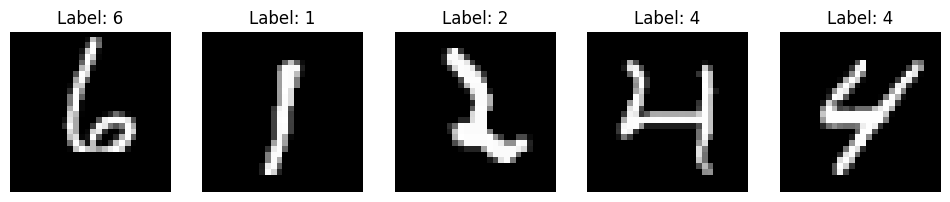

In [ ]:
# Plot the random 5 images from `train_data_full`
plot_images(train_dataset, num_images=5)

**Exercise 5 [10/10]**: To apply SGD with mini-batch, we need `DataLoader` to load the data as mini-batches. Additionally, to moniter the performance not only during the training but also the test dataset (or validation dataset for tuning), we need both `train_loader` and `test_loader`.
1. Define `batch_size` with size value `64`
2. Define `train_loader` using `DataLoader`, ensuring the `shuffle=True` flag is set to randomly shuffle the training data after each epoch.
3. Define `test_loader` using `DataLoader` for the test dataset, and since it’s not necessary to shuffle the test data, you can leave the shuffle flag as the default (False).


In [ ]:
# Create DataLoaders
### Code Here ###

### Code Here ###
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Now that we have the training and test datasets ready in **mini-batch form**, we can define our `model`, loss `criterion`, and `optimizer` to start training.

**Exercise 6 [10/10]:**
1. Use `ShallowNet` to define a two-layer network `model` with `10` hidden units and `n_y=10` as MNIST contains `10` digits.
2. Specify the loss critarion to be `nn.MSELoss()`
3. Define SGD optimizer using `torch.optim.SGD()` by passing the learning rate and the model's parameters
4. For each epoch, we loop over each mini-batch `(inputs, targets)` loaded from `train_loader`:
  - Since each image in `inputs` has shape `28x28`, but the MLP treats input as a **vector**, reshape inputs using `.view(-1)` to flatten the images.
  - Compute the `outputs` by passing the `inputs` through the `model`
  - The model is designed for `10` output classes, but targets are integer values (class labels). Convert targets to **One-Hot Encoding** using `torch.nn.functional.one_hot(targets, num_classes=10)`.
  - Compute the `train_loss` using `critarion` on `outputs` and `targets`
  - Accumulate the `train_loss` into `train_running_loss`
  - Perform gradient computation and take the optimization step to update model's parameters.
  - Apply the same steps to `test_loader` to compute `test_loss` and update `test_running_loss`, excpet for skipping gradient computaiton and optimization steps

5. At end of each epoch, store the averaged `train_running_loss` and `test_running_loss` into `train_losses` and `test_losses`, respecitvely.



In [ ]:
from torch.nn.functional import one_hot

torch.manual_seed(0) # For reproduce

n_y = 10 # 10 classes
model = ShallowNet(n_x=28*28, n_h=10, n_y=n_y)
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
num_epochs = 10
for epoch in range(num_epochs):
    train_running_loss = 0.0
    test_running_loss = 0.0

    # Test loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, targets in test_loader:
            ### Code Here ###


            ### Code Here ###
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            test_running_loss += test_loss.item()

    # Training loop
    model.train()  # Set the model to training mode
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()  # Clear previous gradients
        ### Code Here ###


        ### Code Here ###

        outputs = model(inputs)
        train_loss = criterion(outputs, targets)
        train_running_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()

    train_losses.append(train_running_loss / len(train_loader))
    test_losses.append(test_running_loss / len(test_loader))
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")



Epoch [1/10], Train Loss: 0.0874, Test Loss: 0.1305
Epoch [2/10], Train Loss: 0.0730, Test Loss: 0.0769
Epoch [3/10], Train Loss: 0.0661, Test Loss: 0.0688
Epoch [4/10], Train Loss: 0.0612, Test Loss: 0.0629
Epoch [5/10], Train Loss: 0.0575, Test Loss: 0.0587
Epoch [6/10], Train Loss: 0.0546, Test Loss: 0.0554
Epoch [7/10], Train Loss: 0.0525, Test Loss: 0.0529
Epoch [8/10], Train Loss: 0.0508, Test Loss: 0.0510
Epoch [9/10], Train Loss: 0.0495, Test Loss: 0.0495
Epoch [10/10], Train Loss: 0.0485, Test Loss: 0.0484


Now that we have obtained `train_losses` and `test_losses`, it is essential to check the convergence behavior to determine whether it is smooth without significant damping or oscillation. If oscillations occur, we may need to consider shrinking the learning rate. In this exercise, you will implement a function `plot_losses()` to visualize the losses on the same plot.

**Exercise 7 [10/10]:**
1. We need to import `matplotlib.pyplot` as `plt` as for ploting
2. The function `plot_losses` takes `train_losses` and `test_losses` as input
3. Use `plt.figure()` to define a figure with specified `figsize=(10,6)`
4. Plot train_losses using `plt.plot()`. To distinguish it from `test_losses`, specify parameters such as `label`, `color`, and `linestyle`.
5. Plot `test_losses` as the `train_losses`
6. Add labels and title
7. Add legend
8. Finish ploting, we `plt.show()` the plotted figure.


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))

    # Plot training losses (blue dashed line)
    plt.plot(train_losses, label='Training Loss', color='blue', linestyle='--')

    # Plot test losses (red solid line)
    ### Code Here ###


    ### Code Here ###

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

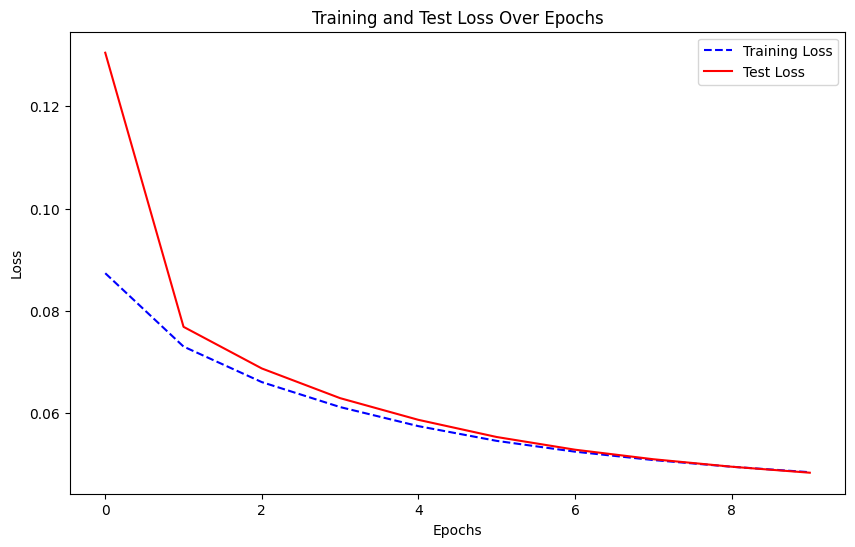

In [ ]:
# Plot the train and test losses
plot_losses(train_losses, test_losses)

Once the model is trained, we can use it to make predictions and calculate the accuracy.

**Exercise 8 [10/10]**:
1. The `predict_and_accuracy` takes a `model` and `data_loader`
2. Loop over the `data_loader`, similar to how you handled the test loop:
 - For each mini-batch, compute the `outputs` by applying the `model` on `inputs`.
 - Use `torch.max(outputs.data, 1)` to retrieve the `predicted` class labels by finding the index of the maximum logit value in `outputs`.
 - We collect the `predicted` labels into the previous collection `predicitons` using `extend()` as to append a `list` to another `list` in Python
 - UUpdate the total number of predictions made (`total`) and the total number of correct predictions (`correct`).
3. After completing the loop, compute the `accuracy` as the ratio of correct predictions to the total number of predictions (`correct / total`).
4. Return total `predicitons` and `accuracy`

In [ ]:
def predict_and_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predictions = []

    with torch.no_grad():  # Disable gradient computation during prediction
        for inputs, targets in data_loader:
            inputs = inputs.view(-1, 28 * 28)  # Flatten the images
            outputs = model(inputs)
            ### Code Here ###


            ### Code Here ###
            predictions.extend(predicted.tolist())
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    ### Code Here ###


    ### Code Here ###
    return predictions, accuracy


In [ ]:
# Train Accuracy:
predictions, accuracy = predict_and_accuracy(model, train_loader)
print(f"Training Accuracy:: {accuracy:.4f}")

Training Accuracy:: 0.8137


In [ ]:
# Test Accuracy
predictions, accuracy = predict_and_accuracy(model, test_loader)
print(f"Testing Accuracy: {accuracy:.4f}")

Testing Accuracy: 0.8259


# 2 - Tuning Hyperparameters

As introduced in the lectures, training deep neural networks (DNNs) involves a variety of choices for hyperparameters, such as:
- chocie of loss funcitons,
- activaiton funcitons,
- leanring rate,
- optimizers,
- network achetecrures,
- etc

In this seciton, we will review the tunning strategies introduced in lectures.



## 2.1 - Train with Cross Entropy Loss [10/10]

Let’s first explore the effect of changing the loss function from mean square error to **cross-entropy loss**. Specifically, we want to check if switching the loss function results in significant differences in training performance.

**Note**: When we define `ShallowNet`, the model outputs raw real values (*logits*). However, when using cross-entropy loss, the loss function expects the input to represent probabilities, where each value is in $[0,1]$ and the sum is euqal to $1$. This is achieved by applying the **softmax** activation function:
$$
b_i = \frac{\exp(a_i)}{\sum_{j=1}^{n} \exp(a_i)}
$$
However, do not apply softmax **manually** in the `ShallowNet` definition, because `nn.CrossEntropyLoss()` automatically applies softmax internally. Applying softmax twice would result in incorrect behavior and training.

**Exercise 9 [10/10]**:
1. Define `model` as `ShallowNet` with `10` hidden units.
2. Specify the loss `criterion` as `nn.CrossEntropyLoss()`.
3. Set the `optimizer` to SGD (with mini-batches), using a learning rate of `0.01`.
4. Train the `mode`l for `10` epochs, recording the `train_losses` and `test_losses` at each epoch.
5. Plot the `train_losses` and `test_losses` to visualize the convergence behavior.
6. Make predictions on both the training and test datasets, and return their respective `accuracy`.

In [ ]:
torch.manual_seed(0) # For reproduce

model = ShallowNet(n_x=28*28, n_h=8, n_y=n_y)
### Code Here ### (Define loss criterion)


### Code Here ###
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
num_epochs = 10
for epoch in range(num_epochs):
    train_running_loss = 0.0
    test_running_loss = 0.0
    # Test loop
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            ### Code Here ###


            ### Code Here ###
            test_running_loss += test_loss.item()

    # Training loop
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear previous gradients
        ### Code Here ###

        ### Code Here ###

    train_losses.append(train_running_loss / len(train_loader))
    test_losses.append(test_running_loss / len(test_loader))
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1/10], Train Loss: 1.3421, Test Loss: 2.3165
Epoch [2/10], Train Loss: 0.5694, Test Loss: 0.6852
Epoch [3/10], Train Loss: 0.4494, Test Loss: 0.4663
Epoch [4/10], Train Loss: 0.4003, Test Loss: 0.4021
Epoch [5/10], Train Loss: 0.3716, Test Loss: 0.3670
Epoch [6/10], Train Loss: 0.3530, Test Loss: 0.3458
Epoch [7/10], Train Loss: 0.3402, Test Loss: 0.3344
Epoch [8/10], Train Loss: 0.3308, Test Loss: 0.3231
Epoch [9/10], Train Loss: 0.3237, Test Loss: 0.3176
Epoch [10/10], Train Loss: 0.3177, Test Loss: 0.3128


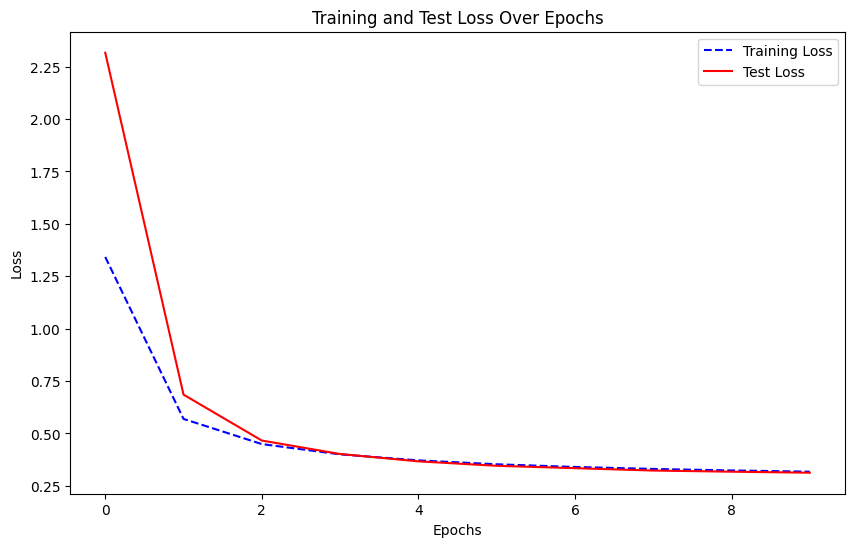

In [ ]:
# Plot the train and test losses
### Code Here ###
plot_losses(train_losses, test_losses)
### Code Here ###

In [ ]:
### Code Here ###
_, train_accuracy = predict_and_accuracy(model, train_loader)
_, test_accuracy = predict_and_accuracy(model, test_loader)
### Code Here ###
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9115
Testing Accuracy: 0.9132


As you can see, using `CrossEntropyLoss()` results in beter `train_losses` and `test_losses` compared to using `MSELoss()`, but the `accuracy` is much better. Hence, the chocie of hyperparameters influence the performance of DNNs.

## 2.2 - Tune network width and learning rate [10/10]

We will use **random search** to tune two hyperparameters: the **width** (number of hidden units) and the **learning rate**.

The possible combinations of learning rate and network width can be represented in a grid as follows:

| Learning Rate \ Width | 2    | 16   | 128  | 1024 |
|-----------------------|------|------|------|------|
| 1                     |val.  |val.  |val.  |val.  |
| 0.1                   |val.  |val.  |val.  |val.  |
| 0.01                  |val.  |val.  |val.  |val.  |
| 0.001                 |val.  |val.  |val.  |val.  |

**Note**: both learning rate and width are in **log scale**.



**Exercise 10 [10/10]**:
The first step is to split the `train_dataset` into `train_data` and `val_data`. Since the MNIST dataset is relatively straightforward, the results are not very sensitive to the choice of hyperparameters. Therefore, we can use a `90/10` split ratio by applying the `random_split(data, [size1, size2])` function.

Next, to simplify the coding process, we will write the training loop as a function `train_model()` that takes `model`, `train_loader`, loss `criterion`, `optimizer` and `num_epoches` as input.

In the third step, we need to define the search space. Create a range of values for both the learning rate and network width, ensuring that both are sampled using **log-scale**. Next, randomly sample `4` learning rates and widths from the defined search space to evaluate different combinations.

For each randomly selected combination of learning rate and width, train the model on the training set and validate it on the validation set. Track the performance (e.g., validation accuracy) for comparison.



In [ ]:
from torch.utils.data import random_split
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

### Code Here ### (random_split train_dataset into train_data and val_data)


### Code Here ###
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

# Redefine valudation set loader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

Number of training samples: 54000
Number of validation samples: 6000


In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            ### Code Here ###




            ### Code Here ###

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}")

In [ ]:
learning_rates = torch.logspace(-3, 0, 5)
widths = [2, 16, 128, 1024]
print(f"Learning Rate: {learning_rates}")
print(f"Width: {widths}")

Learning Rate: tensor([0.0010, 0.0056, 0.0316, 0.1778, 1.0000])
Width: [2, 16, 128, 1024]


In [ ]:
import random
random.seed(4) # For reproducibility
# Sample random combinations of learning rates and widths
random_combinations = [(random.choice(learning_rates), random.choice(widths)) for _ in range(4)]  # Example with 20 combinations
print(f"Random Combinations: {random_combinations}")

Random Combinations: [(tensor(0.0056), 128), (tensor(0.0010), 1024), (tensor(0.1778), 16), (tensor(0.0010), 2)]


In [ ]:
best_params = None
best_val_accuracy = 0.0

for lr, width in random_combinations:
    print(f"Training with Learning Rate = {lr:.6f}, Width = {width}")

    torch.manual_seed(0)  # For reproducibility
    # Build and initialize the model with the given width
    model = ShallowNet(n_x=28*28, n_h=width, n_y=n_y)

    # Define the optimizer with the sampled learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Define loss criterion
    criterion = nn.CrossEntropyLoss()

    # Train the model on the training set
    ### Code Here ###


    ### Code Here ###

    # Validate the model on the validation set
    ### Code Here ###


    ### Code Here ###

    # Track the best-performing combination
    ### Code Here ###
    if
    ### Code Here ###
        best_val_accuracy = val_accuracy
        best_params = (lr, width)

print(f"Best parameters found: Learning Rate = {best_params[0]}, Width = {best_params[1]}")

Training with Learning Rate = 0.005623, Width = 128
Epoch [1/10], Loss: 1.6581
Epoch [2/10], Loss: 0.7577
Epoch [3/10], Loss: 0.5312
Epoch [4/10], Loss: 0.4482
Epoch [5/10], Loss: 0.4049
Epoch [6/10], Loss: 0.3779
Epoch [7/10], Loss: 0.3588
Epoch [8/10], Loss: 0.3442
Epoch [9/10], Loss: 0.3323
Epoch [10/10], Loss: 0.3223
Training with Learning Rate = 0.001000, Width = 1024
Epoch [1/10], Loss: 2.1743
Epoch [2/10], Loss: 1.8915
Epoch [3/10], Loss: 1.5737
Epoch [4/10], Loss: 1.2786
Epoch [5/10], Loss: 1.0545
Epoch [6/10], Loss: 0.8986
Epoch [7/10], Loss: 0.7903
Epoch [8/10], Loss: 0.7127
Epoch [9/10], Loss: 0.6548
Epoch [10/10], Loss: 0.6100
Training with Learning Rate = 0.177828, Width = 16
Epoch [1/10], Loss: 0.4211
Epoch [2/10], Loss: 0.2501
Epoch [3/10], Loss: 0.2155
Epoch [4/10], Loss: 0.1946
Epoch [5/10], Loss: 0.1815
Epoch [6/10], Loss: 0.1732
Epoch [7/10], Loss: 0.1668
Epoch [8/10], Loss: 0.1619
Epoch [9/10], Loss: 0.1551
Epoch [10/10], Loss: 0.1495
Training with Learning Rate = 0

In [ ]:
# Train with the best parameters
torch.manual_seed(0)
model = ShallowNet(n_x=28*28, n_h=best_params[1], n_y=n_y)
optimizer = torch.optim.SGD(model.parameters(), lr=best_params[0])
train_model(model, train_loader, criterion, optimizer)

Epoch [1/10], Loss: 0.4211
Epoch [2/10], Loss: 0.2501
Epoch [3/10], Loss: 0.2155
Epoch [4/10], Loss: 0.1946
Epoch [5/10], Loss: 0.1815
Epoch [6/10], Loss: 0.1732
Epoch [7/10], Loss: 0.1668
Epoch [8/10], Loss: 0.1619
Epoch [9/10], Loss: 0.1551
Epoch [10/10], Loss: 0.1495


In [ ]:
_, train_accuracy = predict_and_accuracy(model,train_loader)
_, val_accuracy = predict_and_accuracy(model,val_loader)
_, test_accuracy = predict_and_accuracy(model,test_loader)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9624
Validation Accuracy: 0.9495
Testing Accuracy: 0.9538


# 3- Overparameterizaiton

In the lectures, we introduced the concept of overparameterization, where models are built with many more parameters or hidden units than necessary. Here, we define a shallow network with a large number of hidden units, specifically 2048, and use a high learning rate of 1.

Because we use a much larger width, the model complexity increases, leading to lower bias and potentially good performance on the training set. However, due to high variance, this may not translate to the test set.

Interestingly, the following experiments will demonstrate that an overparameterized model not only struggles to achieve good performance on the training set but can also generalize to the test set. Additionally, the model can be successfully trained even with a large learning rate.

In [ ]:
torch.manual_seed(0) # for reproduct
width = 2048 # large width
model = ShallowNet(n_x=28*28, n_h=width, n_y=10)
learning_rate = 1.0
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print(f"Training with Learning Rate = {learning_rate}, Width = {width}")
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Training with Learning Rate = 1.0, Width = 2048
Epoch [1/10], Loss: 0.2541
Epoch [2/10], Loss: 0.0846
Epoch [3/10], Loss: 0.0558
Epoch [4/10], Loss: 0.0360
Epoch [5/10], Loss: 0.0240
Epoch [6/10], Loss: 0.0158
Epoch [7/10], Loss: 0.0094
Epoch [8/10], Loss: 0.0066
Epoch [9/10], Loss: 0.0038
Epoch [10/10], Loss: 0.0015


In [ ]:
_, train_accuracy = predict_and_accuracy(model,train_loader)
_, val_accuracy = predict_and_accuracy(model,val_loader)
_, test_accuracy = predict_and_accuracy(model,test_loader)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Validation Accuracy: 0.9852
Testing Accuracy: 0.9846
